In [3]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# load modules related to this exercise
from TwoAssetModel import TwoAssetModelClass 
import estimate

import numba as nb
nb.set_num_threads(8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model

In [9]:
model = TwoAssetModelClass(
    name='example_negm',
    par={
        'solmethod':'negm',
        'T':15, # shorten the life cycle
        'Tmin':0,
        'Tr':10,
        'moments_numsim':1,
        'do_print':False
        })
model.precompile_numba() # solve with very coarse grids
model.solve()
model.simulate()

par = model.par
sol = model.sol
sim = model.sim

## Data / obtaining the empirical moments for a and y

We tried using true empirical moments from Statistics Denmark scaled to match those of the model. This part unfortunately didn't work out.

In [5]:
# read data from statistikbanken
df_y = pd.read_excel('data/y.xlsx',sheet_name='y',header=0)
df_a = pd.read_excel('data/a.xlsx',sheet_name='a',header=0)

#interpolating between age intervals
df_y = df_y.interpolate(method='linear',axis=0)
df_a = df_a.interpolate(method='linear',axis=0)

for df in [df_y,df_a]:
    df.rename(columns={'Unnamed: 0': 'age'}, inplace=True)

#dropping unnecessary rows/cols
mask = df_a.age.isin(range(18,25))
df_a = df_a.loc[~mask].copy(deep=True)

#to np array
y = df_y.drop(columns='age').to_numpy().mean(axis=1)
a = df_a.drop(columns='age').to_numpy().mean(axis=1)

# join into one 56x2 array
mean_data = np.array([a,y])#[:,:30]

## MOMENTS USING MEAN FOR a AND y

In [6]:
# save true parameters
par_beta = copy.copy(par.beta)
par_rho = copy.copy(par.rho)

# data / empirical moments
data = copy.copy(sim)
data.moments = estimate.calc_moments(par,data)  

# data.moments = mean_data  # replace this with 
# scale_y = model.sim.y.mean()/mean_data[:,1].mean()  
# data.moments *= scale_y # scale empirical moments to be of similar scale as simulated moments


In [7]:
Nbeta = 5 # number of beta values to try
beta = np.linspace(0.955,0.975,Nbeta) # values of betas to try
obj = np.nan + np.zeros((Nbeta)) # objective function

count = 1
for i in range(Nbeta):
    np.random.seed(1999)   # fix seed 
    print(f"{count} / {Nbeta}")
    est_par = ['beta']
    theta0 = [beta[i]]
    obj[i] = estimate.sum_squared_diff_moments(theta0,model,est_par,data)
    count += 1

#Re-inset the true parameters 
par.beta = copy.copy(par_beta)

1 / 5
2 / 5
3 / 5
4 / 5
5 / 5


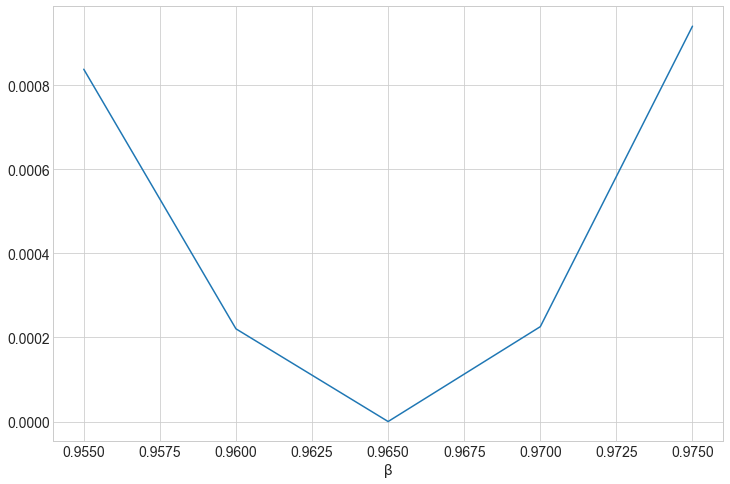

In [8]:
plt.figure(figsize=(12,8)) # figsize is in inches...
plt.plot(beta,obj[:])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(f'\u03B2',fontsize=15)
plt.savefig('output/estimate_beta.png')
plt.show()